In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import gaussian_kde
from tqdm import tqdm
from hscpy import camira
from pathlib import Path
from astropy.io import ascii
from astropy import units as u
from astropy.table import Column
from astropy.cosmology import Planck15 as cosmo
from astropy.coordinates import SkyCoord
from more_itertools import unique_everseen
import heapq
import gzip
import csv
import json
import pandas as pd
import pprint
import sys

In [2]:
# read in data file
data = np.genfromtxt('Galaxy_Data_Oguri', dtype=None)

# arrays of all unique values, length = 26746.
ra = [float(data[0][0])]
dec = [float(data[0][1])]
Ncor = [float(data[0][2])]
redshift = [float(data[0][3])]

# initalise arrays (unweighted and weighted), cluster specific
all_w = []
all_U = []
all_Q = []
all_alpha = []
all_phi = []
all_Uw = []
all_Qw = []
all_alphaw = []
all_phiw  = []
all_clu_ra = []
all_clu_dec = []
all_corrected_x = []
all_corrected_y = [] # simply dec - mean
angle = []
clu_size = []
centre_ra = []
centre_dec = []

# BCG specific
all_U_bcg = []
all_Q_bcg = []
all_alpha_bcg = []
all_phi_bcg = []
all_Uw_bcg = []
all_Qw_bcg = []
all_alphaw_bcg = []
all_phiw_bcg = []
all_bcg_ra = []
all_bcg_dec = []
all_cor_bcg_x = []
all_cor_bcg_y = []

# create array for cluster values, length = 8.
cluster1 = np.zeros(len(data[1]))

# ra and dec for cluster
ra_clust = data[0][0]
dec_clust = data[0][1]

In [3]:
for list in tqdm(data):
    if list[0] == ra_clust and list[1] == dec_clust:
        cluster1 = np.vstack([cluster1, list])
    else:
        # build cluster array, delete first row (of zeroes)
        cluster1 = np.delete(cluster1, 0, 0)
        cluster1_ra = cluster1[:, 4]
        cluster1_dec = cluster1[: ,5]
        cluster1_w = cluster1[:, 7]
        length = len(cluster1_ra)
        all_clu_ra.append(cluster1[:,4])
        all_clu_dec.append(cluster1[:,5])
        all_w.append(cluster1[:,7])
        clu_size.append(length)
        cluster1_x = [0] * len(cluster1_ra) # x_value
        cluster1_y = [0] * len(cluster1_ra) # y_value
        ra_mean = np.mean(cluster1_ra)
        dec_mean = np.mean(cluster1_dec)
        centre_ra.append(ra_mean)
        centre_dec.append(dec_mean)
        
        for i in range(len(cluster1_ra)):
            cluster1_x[i] = (cluster1_ra[i] - ra_mean) * math.cos(math.radians(ra_mean))
            cluster1_y[i] = cluster1_dec[i] - dec_mean 
        
        x_min = min(cluster1_x); x_max = max(cluster1_x)
        y_min = min(cluster1_y); y_max = max(cluster1_y)
        
        r = [0] * len(cluster1_ra)
        Mxx_t = 0; Mxy_t = 0; Myy_t = 0
        
        for i in range(len(cluster1_ra)):
            r[i] = math.sqrt((cluster1_x[i])**2 + (cluster1_y[i])**2)
            Mxx_t += (cluster1_x[i])**2 / r[i]**2
            Mxy_t += (cluster1_x[i]) * (cluster1_y[i]) / r[i]**2
            Myy_t += (cluster1_y[i])**2 / r[i]**2
                
        Mxx = Mxx_t / len(cluster1_ra)
        Mxy = Mxy_t / len(cluster1_ra)
        Myy = Myy_t / len(cluster1_ra)
        Q = 2*Mxx-1
        U = 2*Mxy
        D = math.sqrt(Q**2+U**2)
        phi = np.arctan((U/Q)) * 0.5
        alpha = (1-D)/(1+D)
        all_U.append(U)
        all_Q.append(Q)
        all_alpha.append(alpha)
        all_phi.append(phi)
        all_corrected_x.append(cluster1_x)
        all_corrected_y.append(cluster1_y)
        angle.append(math.degrees(phi))
 
        # calculate weighted
        x_wt = 0; y_wt = 0
        
        for i in range(len(cluster1_ra)):
            x_wt += cluster1_x[i] * cluster1_w[i]
            y_wt += cluster1_y[i] * cluster1_w[i]
            
        x_w = x_wt / sum(cluster1_w)
        y_w = y_wt / sum(cluster1_w)
        Mxx_tw = 0; Mxy_tw = 0; Myy_tw = 0
        
        for i in range(len(cluster1_ra)):
            r[i] = math.sqrt((cluster1_x[i])**2 +(cluster1_y[i])**2)
            Mxx_tw += (cluster1_x[i])**2 / r[i]**2 * cluster1_w[i]
            Mxy_tw += (cluster1_x[i])*(cluster1_y[i]) / r[i]**2 * cluster1_w[i]
            Myy_tw += (cluster1_y[i])**2 / r[i]**2 * cluster1_w[i]
        
        Mxx_w = Mxx_tw / sum(cluster1_w)
        Mxy_w = Mxy_tw / sum(cluster1_w)
        Myy_w = Myy_tw / sum(cluster1_w)
        Q_w = 2*Mxx_w-1
        U_w = 2*Mxy_w
        D_w = math.sqrt(Q_w**2+U_w**2)
        phi_w = np.arctan((U_w / Q_w)) * 0.5
        alpha_w = (1-D_w) /(1+D_w)
        all_Uw.append(U_w)
        all_Qw.append(Q_w)
        all_alphaw.append(alpha_w)
        all_phiw.append(phi_w)

        # redefine for convenience
        ra_clust = list[0]
        dec_clust = list[1]
        ra.append(ra_clust)
        dec.append(dec_clust)
        Ncor.append(list[2])
        redshift.append(list[3])
        cluster1 = np.zeros(len(data[1]))
        cluster1 = np.vstack([cluster1, list])
        
del ra[-1]
del dec[-1]
del Ncor[-1]
del redshift[-1]

100%|██████████| 600333/600333 [00:09<00:00, 60456.66it/s]


In [4]:
all_w_expand = []
for i in range(len(all_w)):
    for j in range(len(all_w[i])):
        all_w_expand.append(all_w[i][j])

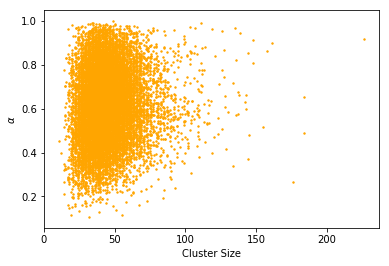

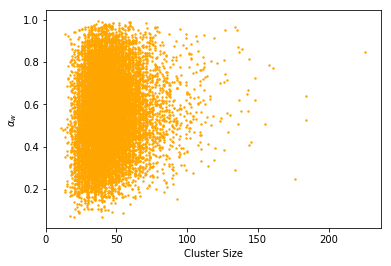

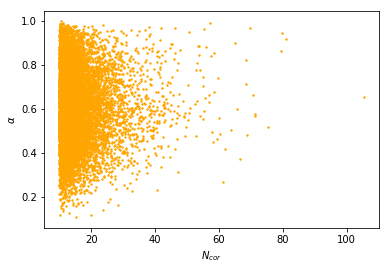

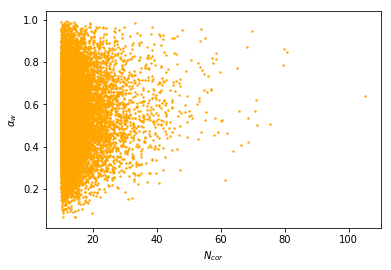

In [5]:
plt.scatter(clu_size, all_alpha, c='orange', s=2)
plt.xlabel('Cluster Size')
plt.ylabel(r'$\alpha$')
plt.show()

plt.scatter(clu_size, all_alphaw, c='orange', s=2)
plt.xlabel('Cluster Size')
plt.ylabel(r'$\alpha_w$')
plt.show()

plt.scatter(Ncor, all_alpha, c='orange', s=2)
plt.xlabel(r'$N_{cor}$')
plt.ylabel(r'$\alpha$')
plt.show()

plt.scatter(Ncor, all_alphaw, c='orange', s=2)
plt.xlabel(r'$N_{cor}$')
plt.ylabel(r'$\alpha_w$')
plt.show()

alpha = 0.9497041740734582
Ncor = 12.399
ra (cluster) = 28.970458
dec (cluster) = -5.366663
min ra = 28.920667
max ra = 29.01454
min dec = -5.415352
max dec = -5.322302
number of data points = 44
angle = 4.422250761393769
Q = -0.025489903533410296
U = -0.0039663204227425785


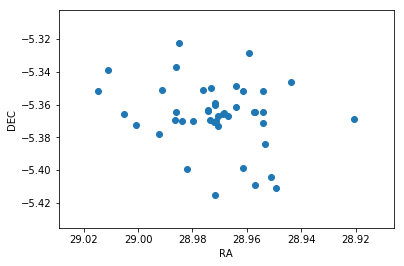

/home/sam/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


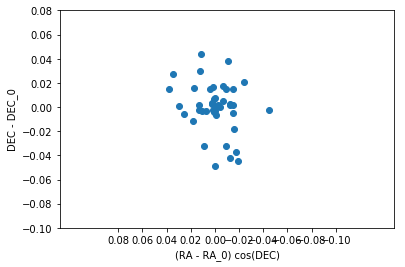

-------------
alpha = 0.8934630312689164
Ncor = 39.444
ra (cluster) = 29.260628
dec (cluster) = -4.560942
min ra = 29.216293
max ra = 29.301957
min dec = -4.610594
max dec = -4.516577
number of data points = 65
angle = -17.766653016429057
Q = -0.04578775531594648
U = 0.032700263631293684


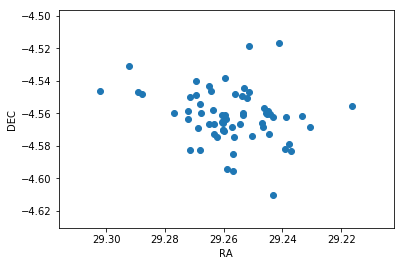

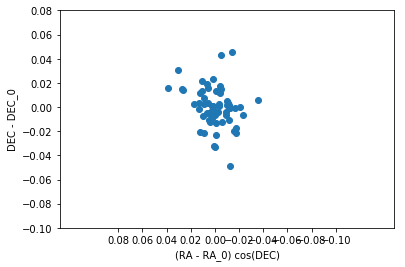

-------------
alpha = 0.8470383438906798
Ncor = 23.267
ra (cluster) = 30.143416
dec (cluster) = -5.449417
min ra = 30.064954
max ra = 30.244958
min dec = -5.542834
max dec = -5.350843
number of data points = 63
angle = -3.873074898213294
Q = -0.08205886732958267
U = 0.011162105379753547


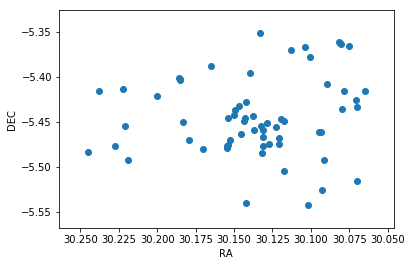

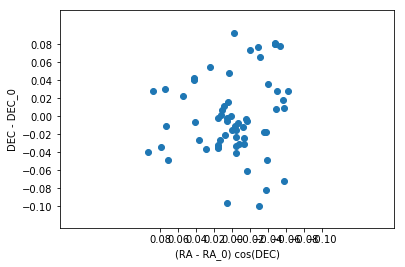

-------------
alpha = 0.8481696455617423
Ncor = 24.008
ra (cluster) = 32.79381
dec (cluster) = -4.344772
min ra = 32.726766
max ra = 32.85534
min dec = -4.391013
max dec = -4.299742
number of data points = 59
angle = 11.450216905356445
Q = 0.07567674300689275
U = 0.03196778303307128


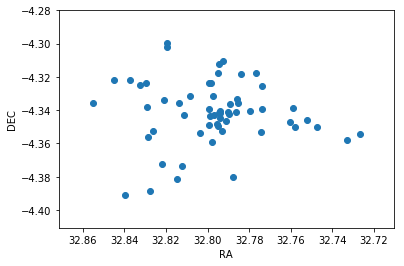

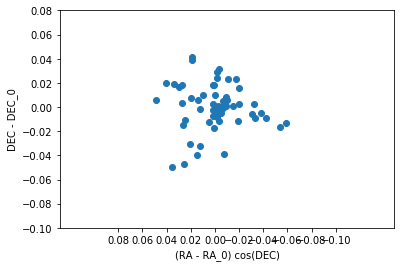

-------------
alpha = 0.9211504409637813
Ncor = 22.31
ra (cluster) = 30.105608
dec (cluster) = -4.502729
min ra = 30.058843
max ra = 30.148763
min dec = -4.5272
max dec = -4.455906
number of data points = 48
angle = 39.405376827771114
Q = -0.00796438174708658
U = -0.04026272638448685


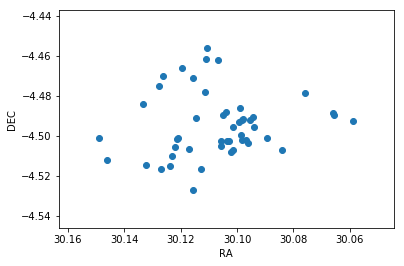

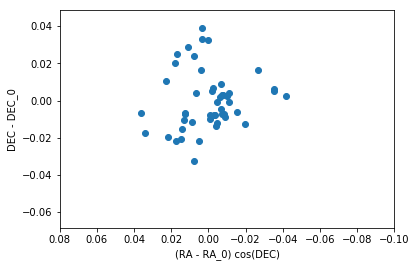

-------------
alpha = 0.9402121924553059
Ncor = 20.842
ra (cluster) = 31.540365
dec (cluster) = -6.45656
min ra = 31.498149
max ra = 31.585249
min dec = -6.490333
max dec = -6.40936
number of data points = 65
angle = 31.83697330966349
Q = 0.013665837593094698
U = 0.027619096126257698


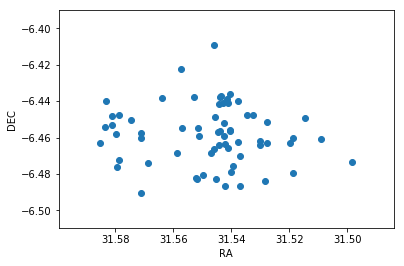

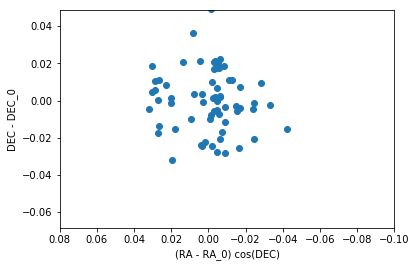

-------------
alpha = 0.8552332772141572
Ncor = 18.956
ra (cluster) = 32.872292
dec (cluster) = -5.209412
min ra = 32.828174
max ra = 32.9074
min dec = -5.250749
max dec = -5.166387
number of data points = 50
angle = 44.21243169756531
Q = -0.0021449200219970654
U = -0.0780020618658117


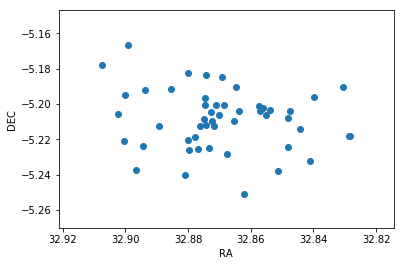

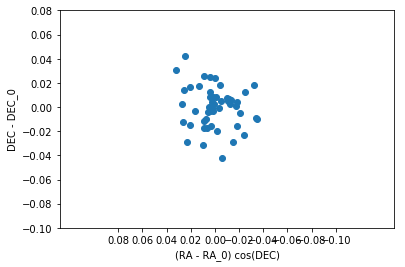

-------------
alpha = 0.8386068898757897
Ncor = 15.943
ra (cluster) = 29.88078
dec (cluster) = -6.273952
min ra = 29.83434
max ra = 29.92785
min dec = -6.330343
max dec = -6.246766
number of data points = 32
angle = 25.998100414498207
Q = -0.054047416899918765
U = -0.06916808489951726


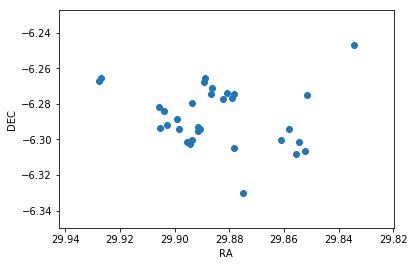

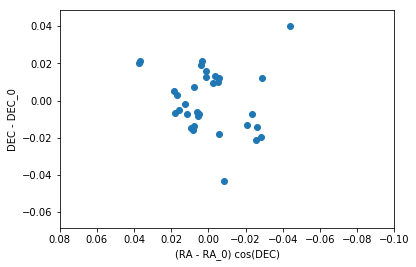

-------------
alpha = 0.8654186270781419
Ncor = 17.054
ra (cluster) = 31.587553
dec (cluster) = -5.014368
min ra = 31.540611
max ra = 31.629959
min dec = -5.079123
max dec = -4.962514
number of data points = 32
angle = -32.45476447659879
Q = -0.030593171015086296
U = 0.06533771208853896


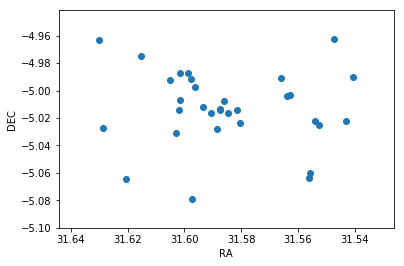

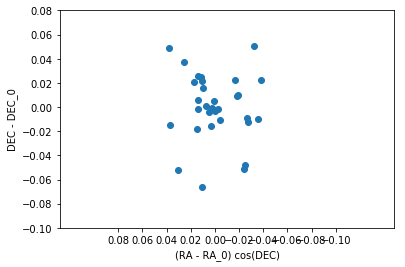

-------------
alpha = 0.8752452163333936
Ncor = 17.018
ra (cluster) = 31.361044
dec (cluster) = -6.201546
min ra = 31.312704
max ra = 31.408026
min dec = -6.248465
max dec = -6.156215
number of data points = 58
angle = -19.349233994677117
Q = -0.05192094954751891
U = 0.04159424500067519


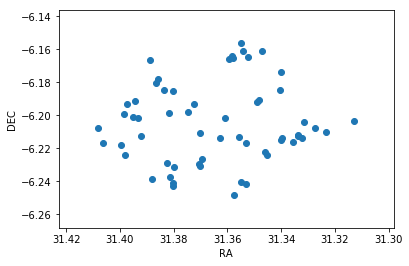

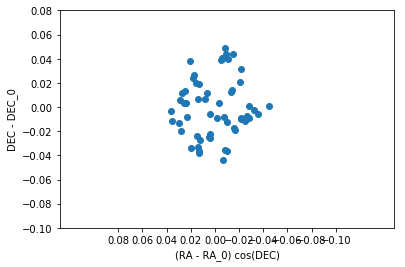

-------------
alpha = 0.891195815574785
Ncor = 17.355
ra (cluster) = 31.060714
dec (cluster) = -6.294213
min ra = 31.024515
max ra = 31.102176
min dec = -6.337767
max dec = -6.249643
number of data points = 57
angle = -40.121762368249506
Q = 0.009749415284699747
U = -0.05669986113673028


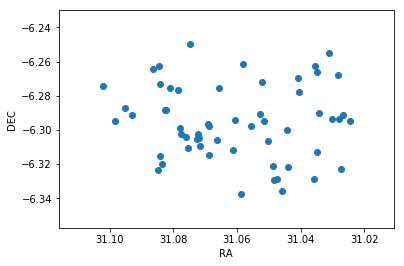

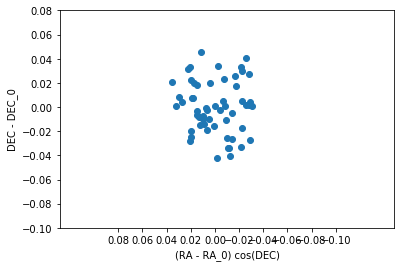

-------------
alpha = 0.951970717622431
Ncor = 15.981
ra (cluster) = 30.426623
dec (cluster) = -4.688025
min ra = 30.313039
max ra = 30.542126
min dec = -4.784388
max dec = -4.56677
number of data points = 47
angle = 39.52823961559169
Q = 0.004671145757413342
U = 0.024158077609779012


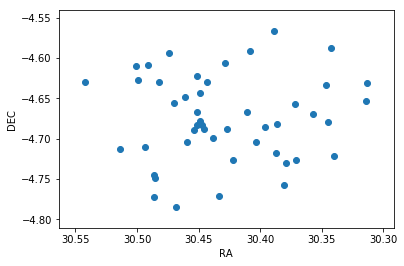

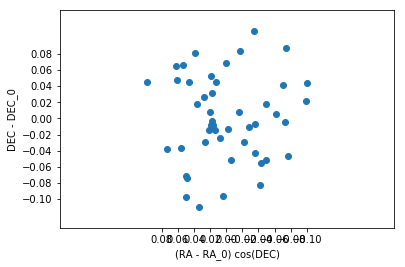

-------------
alpha = 0.8215996420305859
Ncor = 15.063
ra (cluster) = 31.154059
dec (cluster) = -5.666503
min ra = 31.115442
max ra = 31.194269
min dec = -5.701629
max dec = -5.621362
number of data points = 58
angle = 10.075838832372146
Q = -0.09194083121058272
U = -0.033739628266954716


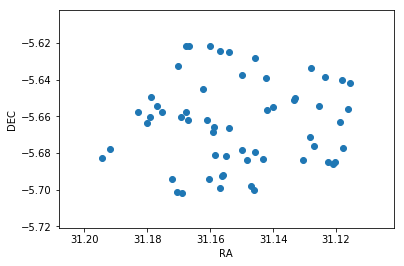

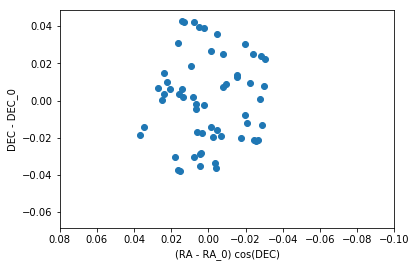

-------------
alpha = 0.9152216461161986
Ncor = 16.176
ra (cluster) = 31.028686
dec (cluster) = -4.707872
min ra = 30.982678
max ra = 31.073404
min dec = -4.750914
max dec = -4.665547
number of data points = 59
angle = 27.812602993980768
Q = 0.02499250899173222
U = 0.03653510742108795


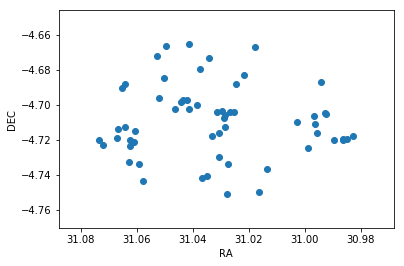

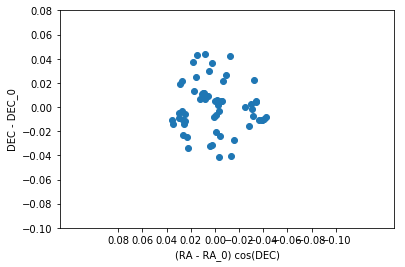

-------------
alpha = 0.8209821736127262
Ncor = 16.761
ra (cluster) = 32.903738
dec (cluster) = -5.295785
min ra = 32.864624
max ra = 32.939164
min dec = -5.340354
max dec = -5.254058
number of data points = 40
angle = -11.774414093556652
Q = -0.09012125999646425
U = 0.039277195858915814


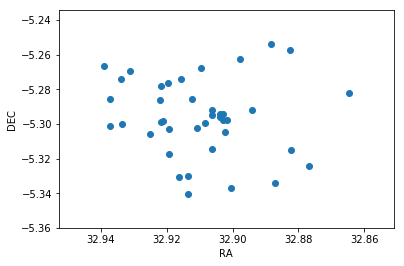

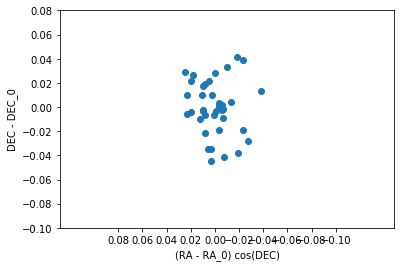

-------------
alpha = 0.8448451504424414
Ncor = 15.243
ra (cluster) = 31.791938
dec (cluster) = -4.339349
min ra = 31.734279
max ra = 31.822851
min dec = -4.393899
max dec = -4.279477
number of data points = 41
angle = 21.753162288883022
Q = -0.06099891984806305
U = -0.05789861183916094


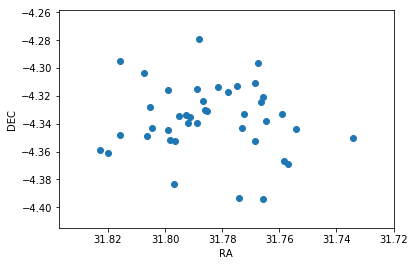

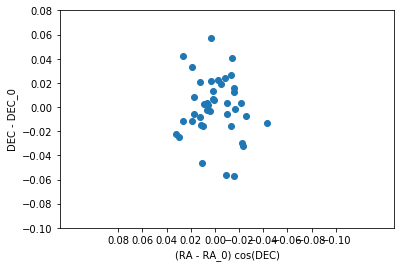

-------------
alpha = 0.8851605426063052
Ncor = 16.529
ra (cluster) = 31.301508
dec (cluster) = -5.260844
min ra = 31.256383
max ra = 31.347044
min dec = -5.309619
max dec = -5.228857
number of data points = 62
angle = 34.22871497077608
Q = 0.02236848091369814
U = 0.05666220212655008


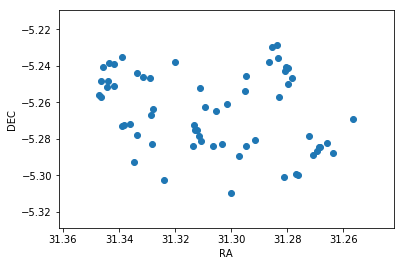

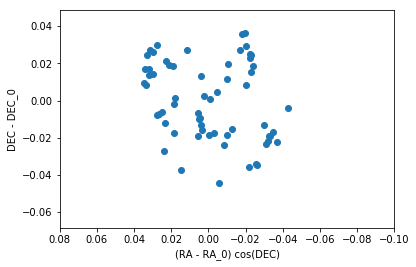

-------------
alpha = 0.8546591831068613
Ncor = 15.481
ra (cluster) = 30.586911
dec (cluster) = -5.91886
min ra = 30.490335
max ra = 30.680205
min dec = -6.028307
max dec = -5.799993
number of data points = 67
angle = 20.75198290901187
Q = -0.058688502476818116
U = -0.05193044319651883


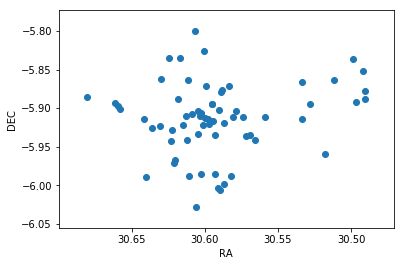

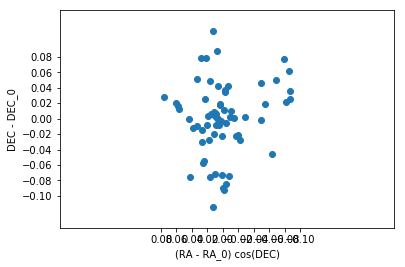

-------------
alpha = 0.8175657358068379
Ncor = 18.247
ra (cluster) = 30.468156
dec (cluster) = -5.003194
min ra = 30.37233
max ra = 30.570433
min dec = -5.105958
max dec = -4.913945
number of data points = 57
angle = 10.053365931998718
Q = 0.0942555188294536
U = 0.03450517971849024


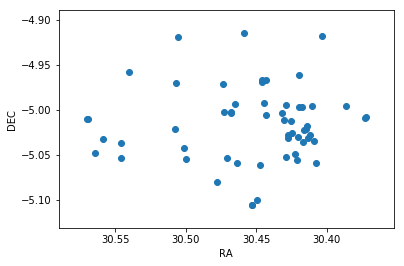

KeyboardInterrupt: 

In [49]:
'''
Cluster Maps (with Euclidean Transform)

Warning: this section of code has the potential to generate
         a large number of files.
'''

coord_array = []
for i in range(len(all_alpha)):
    if (all_alpha[i] > 0.8): # and (all_phiw[i] > 30):
        print('alpha = ' + str(all_alpha[i]))
        print('Ncor = ' + str(Ncor[i]))
        print('ra (cluster) = ' + str(ra[i]))
        print('dec (cluster) = ' + str(dec[i]))
        #print('')
        
        for j in range(len(all_clu_ra[i])):
            coord_array.append([all_clu_ra[i][j], all_clu_dec[i][j]])
        
        name = 'cluster' + str(ra[i]) + '_' + str(dec[i]) + '.css'
        file=open(name,'w')
        file.write('"# ra","dec"\n')
        x_total = 0
        y_total = 0
        Mxxt = 0
        Mxyt = 0
        Myyt = 0
        
        for k in range(len(coord_array)):
            x_total += coord_array[k][0]
            y_total += coord_array[k][1]
            file.write('"' + str(coord_array[k][0]) + '","' + str(coord_array[k][1]) + '"\n')
        
        x_mean = x_total / len(coord_array)
        y_mean = y_total / len(coord_array)
    
        for k in range(len(coord_array)):
            x = (coord_array[k][0] - x_mean) * math.cos(math.radians(y_mean))
            y = coord_array[k][1] - y_mean
            r = math.sqrt(x**2 + y**2)
            #print(str(x) + ' ' + str(y) + ' ' + str(math.sqrt(x**2 + y**2)))
            Mxxt += x**2 / r**2
            Mxyt += x*y / r**2
            Myyt += y**2 / r**2
            Mxx = Mxxt / len(coord_array)
            Mxy = Mxyt / len(coord_array)
            Myy = Myyt / len(coord_array)
            
        Q = 2*Mxx - 1
        U = 2*Mxy
        D = math.sqrt(Q**2 + U**2)
        file.close()    
        print('min ra = ' + str(min(all_clu_ra[i][:])))
        print('max ra = ' + str(max(all_clu_ra[i][:])))
        print('min dec = ' + str(min(all_clu_dec[i][:])))
        print('max dec = ' + str(max(all_clu_dec[i][:])))
        print("number of data points = " + str(len(coord_array)))
        print("angle = " + str(angle[i]))
        print("Q = " + str(all_Q[i]))
        print("U = " + str(all_U[i]))
        
        #print("BCG ra = " + str(BCG_ra[i]))
        #print("BCG dec = " + str(BCG_dec[i]))
        #print("BCG alpha = " + str(alpha_BCG[i]))
        #print("BCG angle = " + str(phi_BCG[i]))
        plt.scatter(all_clu_ra[i], all_clu_dec[i])
        #plt.xlim(min(all_clu_ra[i])-0.05, min(all_clu_ra[i])+0.3)
        #plt.xticks(np.arange(min(all_clu_ra[i]), max(all_clu_ra[i])+.05, .05))
        #plt.yticks(np.arange(min(all_clu_dec[i]), max(all_clu_dec[i])+.05, .05))
        plt.gca().invert_xaxis()
        plt.xlabel('RA')
        plt.ylabel('DEC')
        plt.show()
        plt.scatter(all_corrected_x[i], all_corrected_y[i])
        plt.xticks(np.arange(-0.1, 0.1, .02))
        plt.yticks(np.arange(-0.1, 0.1, .02))
        plt.gca().invert_xaxis()
        plt.xlabel('(RA - RA_0) cos(DEC)')
        plt.ylabel('DEC - DEC_0')
        plt.show()
        print('-------------')
        coord_array = []

In [ ]:
# generate boxsearch SQL
min_ra_set = []
max_ra_set = []
min_dec_set = []
max_dec_set = []

for i in range(len(all_alpha)):
    min_ra_set.append(min(all_clu_ra[i][:]))
    max_ra_set.append(max(all_clu_ra[i][:]))
    min_dec_set.append(min(all_clu_dec[i][:]))
    max_dec_set.append(max(all_clu_dec[i][:]))

start_bound = 0
size = 50
clu_tot = 13373
clu_end = clu_tot - (clu_tot % size)
clu_range = clu_tot // size
tol = 0.001

for k in range(clu_range):
    text_file = open("SQL" + str(k) + ".txt", "w")
    text_file.write('SELECT\n i_ra, i_dec, i_cmodel_flux, i_cmodel_ellipse_11, i_cmodel_ellipse_12, i_cmodel_ellipse_22\n FROM\n s18a_wide.meas\n LEFT JOIN s18a_wide.meas2 USING (object_id)\n LEFT JOIN s18a_wide.meas3 USING (object_id)\n LEFT JOIN s18a_wide.meas4 USING (object_id)\n WHERE\n')
    start_bound = 0 + (k*size)
    end_bound = start_bound + size

    for i in range(start_bound,end_bound): 
        text_file.write('boxSearch(i_coord, ' + str(min_ra_set[i] - tol) + ', ' + str(max_ra_set[i] + tol) + ', '+ str(min_dec_set[i] - tol) + ', ' + str(max_dec_set[i] + tol) + ') ')
        if (i < end_bound-1):
            text_file.write('OR\n')
        else:
            text_file.write(';')

    text_file.close()

#final set of clusters have to be added separately
text_file = open("SQL267.txt", "w")
text_file.write('SELECT\n i_ra, i_dec, i_cmodel_flux, i_cmodel_ellipse_11, i_cmodel_ellipse_12, i_cmodel_ellipse_22\n FROM\n s18a_wide.meas\n LEFT JOIN s18a_wide.meas2 USING (object_id)\n LEFT JOIN s18a_wide.meas3 USING (object_id)\n LEFT JOIN s18a_wide.meas4 USING (object_id)\n WHERE\n')
start_bound = clu_end
end_bound = clu_tot

for i in range(start_bound,end_bound): 
    text_file.write('boxSearch(i_coord, ' + str(min_ra_set[i] - tol) + ', ' + str(max_ra_set[i] + tol) + ', '+ str(min_dec_set[i] - tol) + ', ' + str(max_dec_set[i] + tol) + ') ')
    if (i < end_bound-1):
        text_file.write('OR\n')
    else:
        text_file.write(';')

text_file.close()

In [ ]:
plt.scatter(all_alpha, all_alphaw, c='orange', s=2)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\alpha_w$')
plt.show()

In [ ]:
alpha_diff = np.zeros(len(all_alpha))
for i in range(len(all_alpha)):
    alpha_diff[i] = all_alpha[i] - all_alphaw[i]
    
plt.scatter(clu_size, alpha_diff, c='orange', s=2)
plt.xlabel('Cluster Size')
plt.ylabel(r'$\alpha - \alpha_w$')
plt.show()    

plt.scatter(Ncor, alpha_diff, c='orange', s=2)
plt.xlabel(r'$N_{cor}$')
plt.ylabel(r'$\alpha - \alpha_w$')
plt.show()

In [ ]:
plt.scatter(redshift, all_alpha, c='red', s=1.5)
plt.xlabel(r'$z$')
plt.ylabel(r'$\alpha$')
plt.show()

In [ ]:
plt.scatter(redshift, all_alphaw, c='red', s=1.5)
plt.xlabel(r'$z$')
plt.ylabel(r'$\alpha_w$')
plt.show()

In [ ]:
plt.scatter(redshift, clu_size, c='green', s=1.5)
plt.xlabel(r'$z$')
plt.ylabel('Cluster Size')
plt.show()

plt.scatter(redshift, Ncor, c='green', s=1.5)
plt.xlabel(r'$z$')
plt.ylabel(r'$N_{cor}$')
plt.show()

In [ ]:
plt.hist(all_alpha, bins='auto')
plt.xlabel(r'$\alpha$')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.hist(all_alphaw, bins='auto')
plt.xlabel(r'$\alpha_w$')
plt.ylabel('Frequency')
plt.show()

In [ ]:
cutoff_z = 0.6
alpha_highz = [float(0)]
alphaw_highz = [float(0)]
for i in range(len(all_alpha)):
    if redshift[i] > cutoff_z:
        alpha_highz.append(all_alpha[i])
        alphaw_highz.append(all_alphaw[i])
del alpha_highz[0] 
del alphaw_highz[0] 

alpha_lowz = [float(0)]
alphaw_lowz = [float(0)]
for i in range(len(all_alpha)):
    if redshift[i] < cutoff_z:
        alpha_lowz.append(all_alpha[i])
        alphaw_lowz.append(all_alphaw[i])
del alpha_lowz[0]
del alphaw_lowz[0]

In [ ]:
plt.hist(alphaw_highz, bins='auto', label='high (z > ' + str(cutoff_z) + ')')
plt.hist(alphaw_lowz, bins='auto', label='low (z < ' + str(cutoff_z) + ')')
plt.xlabel(r'$\alpha_w$')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
values, base = np.histogram(alphaw_lowz)
cumulative_low = np.cumsum(values)
plt.plot(base[:-1], cumulative_low, c='blue')
values, base = np.histogram(alphaw_highz)
cumulative_high = np.cumsum(values)
plt.plot(base[:-1], cumulative_high, c='blue')
plt.xlabel(r'$z$')
plt.ylabel('Frequency')
plt.show()

In [ ]:
fig,ax = plt.subplots()
ax.plot(np.sort(alphaw_highz),np.linspace(0.0,1.0,len(alphaw_highz)), label='high (z > ' + str(cutoff_z)+ ')')
ax.plot(np.sort(alphaw_lowz),np.linspace(0.0,1.0,len(alphaw_lowz)),label='low (z < ' + str(cutoff_z)+ ')')
plt.xlabel(r'$\alpha_w$')
plt.ylabel('Frequency Fraction')
plt.legend()
plt.show()

In [ ]:
stats.ks_2samp(alphaw_highz, alphaw_lowz)

In [ ]:
stats.ks_2samp(alpha_highz, alpha_lowz)

In [ ]:
cluster_size_cutoff = 0
Ncor_cutoff = 0
clu_size_new = []
Ncor_new = []
z_new = []
alpha_new = []
alphaw_new = []
z_new2 = []
alpha_new2 = []
alphaw_new2 = []

for i in range(len(clu_size)):
    if (clu_size[i] > cluster_size_cutoff):
        clu_size_new.append(clu_size[i])
        z_new.append(redshift[i])
        alpha_new.append(all_alpha[i])
        alphaw_new.append(all_alphaw[i])

for i in range(len(Ncor)):
    if (Ncor[i] > Ncor_cutoff):
        Ncor_new.append(Ncor[i])
        z_new2.append(redshift[i])
        alpha_new2.append(all_alpha[i])
        alphaw_new2.append(all_alphaw[i])

plt.scatter(alpha_new, alphaw_new, c='orange', s=1.5)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\alpha_w$' + ' (N > ' + str(Ncor_cutoff) + ')')
plt.show()

regress1 = np.polyfit(alpha_new, alphaw_new, 1)
print(str(regress1[0]) + 'x + ' + str(regress1[1]))
alpha_diff_new = np.zeros(len(alpha_new))
alpha_diff_new2 = np.zeros(len(alpha_new2))
for i in range(len(alpha_new)):
    alpha_diff_new[i] = alpha_new[i] - alphaw_new[i]
    
for i in range(len(alpha_new2)):
    alpha_diff_new2[i] = alpha_new2[i] - alphaw_new2[i]

plt.scatter(Ncor_new, alpha_diff_new2, c='orange', s=2)
plt.xlabel(r'$N_{cor}$' + ' (N > ' + str(Ncor_cutoff) + ')')
plt.ylabel(r'$\alpha - \alpha_w$')
plt.show()

plt.scatter(z_new2, Ncor_new, c='green', s=1.5)
plt.xlabel(r'$z$')
plt.ylabel(r'$N_{cor}$' + ' (N > ' + str(Ncor_cutoff) + ')')
plt.show()

plt.scatter(clu_size_new, alpha_new, c='orange', s=2)
plt.xlabel('Cluster Size')
plt.ylabel(r'$\alpha$')
plt.show()

plt.scatter(clu_size_new, alphaw_new, c='orange', s=2)
plt.xlabel('Cluster Size')
plt.ylabel(r'$\alpha_w$')
plt.show()

plt.scatter(clu_size_new, alpha_diff_new, c='orange', s=2)
plt.xlabel('Cluster Size')
plt.ylabel(r'\alpha_w - \alpha$')
plt.show()

In [ ]:
z_range = np.arange(0.25,0.5,0.0001)
stat = []
stat_w = []
p_val = []
p_val_w = []

for i in tqdm(range(len(z_range))):
    z_cutoff = z_range[i]
    #print(z_cutoff)
    alpha_highz = [float(0)]
    alphaw_highz = [float(0)]
    alpha_lowz = [float(0)]
    alphaw_lowz = [float(0)]

    for j in range(len(all_alpha)):
        if redshift[j] > z_cutoff:
            alpha_highz.append(all_alpha[j])
            alphaw_highz.append(all_alphaw[j])

        elif redshift[j] < z_cutoff:
            alpha_lowz.append(all_alpha[j])
            alphaw_lowz.append(all_alphaw[j])
            
    del alpha_highz[0] 
    del alphaw_highz[0]             
    del alpha_lowz[0]
    del alphaw_lowz[0]

    statistic, pvalue = stats.ks_2samp(alpha_highz, alpha_lowz)
    stat.append(statistic)
    p_val.append(pvalue)
    statistic, pvalue = stats.ks_2samp(alphaw_highz, alphaw_lowz)
    stat_w.append(statistic)
    p_val_w.append(pvalue)
    
plt.scatter(z_range, stat, s = 1, label = 'unweighted')
plt.scatter(z_range, stat_w, s = 1, label = 'weighted')
plt.xlabel('z (cutoff)')
plt.ylabel('K-S Statistic')
plt.show()

plt.scatter(z_range, p_val, s = 1, label = 'unweighted')
plt.scatter(z_range, p_val_w, s = 1, label = 'weighted')
plt.axhline(y=0.1, color='r', linestyle='-')
plt.xlabel('z (cutoff)')
plt.ylabel('P value')
plt.show()

In [5]:
"""
Theoretical galaxy modelling
Goal: to find minimum galaxy number for good alpha
"""
def theory_alpha_circle(gal_num, trials):
    theory_x = []
    theory_y = []
    alpha_theory_all = []
    phi_theory_all = []
    complete = 0

    for j in range(trials):
        while (complete != gal_num):
            x = np.random.uniform(-1,1)
            y = np.random.uniform(-1,1)
            r = math.sqrt(x**2 + y**2)
            if r <= 1:
                theory_x.append(x)
                theory_y.append(y)
                complete += 1

        x_mean = np.mean(theory_x)
        y_mean = np.mean(theory_y)
        Mxx_t = 0
        Mxy_t = 0
        Myy_t = 0
        r = 0

        for i in range(gal_num):
            r = math.sqrt(theory_x[i]**2 + theory_y[i]**2)
            Mxx_t += theory_x[i]**2 / r**2
            Mxy_t += theory_x[i]*theory_y[i] / r**2
            Myy_t += theory_y[i]**2 / r**2

        Mxx = Mxx_t / gal_num
        Mxy = Mxy_t / gal_num
        Myy = Myy_t / gal_num
        Q = 2*Mxx - 1
        U = 2*Mxy 
        D = math.sqrt(Q**2 + U**2)
        alpha_theory = (1-D)/(1+D)
        alpha_theory_all.append(alpha_theory)
        phi_theory = np.arctan((U/Q)) * 0.5
        phi_theory_all.append(phi_theory)
        mean = np.mean(alpha_theory_all)
        stdev = np.std(alpha_theory_all)
        q1 = np.percentile(alpha_theory_all, 25)
        q3 = np.percentile(alpha_theory_all, 75)
        theory_x = []
        theory_y = []
        complete = 0
    return alpha_theory_all, phi_theory_all, mean, stdev, q1, q3
    alpha_theory_all = []

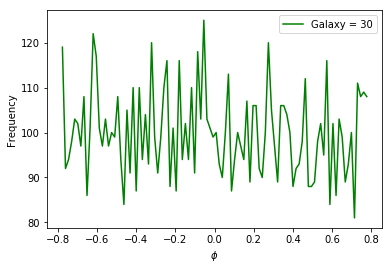

In [8]:
#alpha_theory_all = theory_alpha(2, 10000)
#y, binEdges = np.histogram(alpha_theory_all, bins=100)
#bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
#plt.plot(bincenters,y,'-', label = 'Galaxy = 2')

gal_n = [20,25,30]
trials = 10000

'''
alpha_theory_all, phi_theory_all, mean, stdev, q1, q3 = theory_alpha_circle(gal_n[0], trials)
y, binEdges = np.histogram(alpha_theory_all, bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-', label = 'Galaxy = ' + str(gal_n[0]))

s = np.random.normal(mean, stdev, 10000)
chisquare(alpha_theory_all, s)

alpha_theory_all, phi_theory_all, mean, stdev, q1, q3 = theory_alpha_circle(gal_n[1], trials)
y, binEdges = np.histogram(alpha_theory_all, bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-', label = 'Galaxy = ' + str(gal_n[1]))
s = np.random.normal(mean, stdev, 10000)
chisquare(alpha_theory_all, s)

alpha_theory_all, phi_theory_all, mean, stdev, q1, q3 = theory_alpha_circle(gal_n[2], trials)
y, binEdges = np.histogram(alpha_theory_all, bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-', label = 'Galaxy = ' + str(gal_n[2]))
s = np.random.normal(mean, stdev, 10000)
chisquare(alpha_theory_all, s)
plt.xlabel(r'$\alpha$')
plt.ylabel('Frequency')
plt.legend()
plt.show()

alpha_theory_all, phi_theory_all, mean, stdev, q1, q3 = theory_alpha_circle(gal_n[0], trials)
y, binEdges = np.histogram(phi_theory_all, bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-', label = 'Galaxy = ' + str(gal_n[0]))

s = np.random.normal(mean, stdev, 10000)
chisquare(alpha_theory_all, s)

alpha_theory_all, phi_theory_all, mean, stdev, q1, q3 = theory_alpha_circle(gal_n[1], trials)
y, binEdges = np.histogram(phi_theory_all, bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-', label = 'Galaxy = ' + str(gal_n[1]))
s = np.random.normal(mean, stdev, 10000)
chisquare(alpha_theory_all, s)
'''
alpha_theory_all, phi_theory_all, mean, stdev, q1, q3 = theory_alpha_circle(gal_n[2], trials)
y, binEdges = np.histogram(phi_theory_all, bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-', label = 'Galaxy = ' + str(gal_n[2]), color="green")
s = np.random.normal(mean, stdev, 10000)
chisquare(alpha_theory_all, s)
plt.xlabel(r'$\phi$')
plt.ylabel('Frequency')
plt.legend()
plt.show()



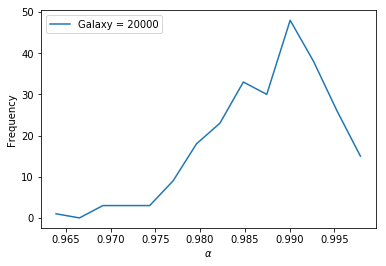

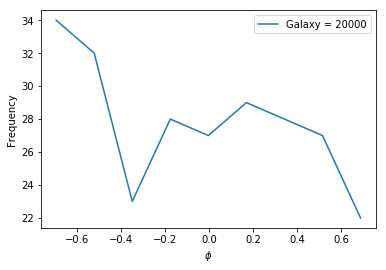

In [6]:
gal_n = 20000
trials = 250
alpha_theory_all, phi_theory_all, mean, stdev, q1, q3 = theory_alpha_circle(gal_n, trials)
y, binEdges = np.histogram(alpha_theory_all, bins='auto')
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-', label = 'Galaxy = ' + str(gal_n))
#s = np.random.normal(mean, stdev, 10000)
#chisquare(alpha_theory_all, s)
plt.xlabel(r'$\alpha$')
plt.ylabel('Frequency')
plt.legend()
plt.show()

y, binEdges = np.histogram(phi_theory_all, bins='auto')
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-', label = 'Galaxy = ' + str(gal_n))
#s = np.random.normal(mean, stdev, 10000)
#chisquare(alpha_theory_all, s)
plt.xlabel(r'$\phi$')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [7]:
def theory_alpha_ellipse(gal_num, trials, a, b):
    range_e = a / b
    theory_x = []
    theory_y = []
    alpha_theory_all = []
    phi_theory_all = []
    complete = 0
    
    for j in range(trials):
        while (complete != gal_num):
            x = np.random.uniform(-range_e,range_e)
            y = np.random.uniform(-1,1)
            eqn = (x**2 / a**2) + (y**2 / b**2)
            if eqn <= 1:
                theory_x.append(x)
                theory_y.append(y)
                complete += 1

        x_mean = np.mean(theory_x)
        y_mean = np.mean(theory_y)
        Mxx_t = 0
        Mxy_t = 0
        Myy_t = 0
        r = 0

        for i in range(gal_num):
            r = math.sqrt(theory_x[i]**2 + theory_y[i]**2)
            Mxx_t += theory_x[i]**2 / r**2
            Mxy_t += theory_x[i]*theory_y[i] / r**2
            Myy_t += theory_y[i]**2 / r**2

        Mxx = Mxx_t / gal_num
        Mxy = Mxy_t / gal_num
        Myy = Myy_t / gal_num
        Q = 2*Mxx - 1
        U = 2*Mxy 
        D = math.sqrt(Q**2 + U**2)
        alpha_theory = (1-D)/(1+D)
        alpha_theory_all.append(alpha_theory)
        phi_theory = np.arctan((U/Q)) * 0.5
        phi_theory_all.append(phi_theory)
        mean_a = np.mean(alpha_theory_all)
        stdev_a = np.std(alpha_theory_all)
        q1_a = np.percentile(alpha_theory_all, 25)
        q3_a = np.percentile(alpha_theory_all, 75)
        mean_p = np.mean(phi_theory_all)
        stdev_p = np.std(phi_theory_all)
        q1_p = np.percentile(phi_theory_all, 25)
        q3_p = np.percentile(phi_theory_all, 75)
        
        #plt.scatter(theory_x, theory_y)
        #plt.show()

        theory_x = []
        theory_y = []
        complete = 0
    return alpha_theory_all, phi_theory_all, mean_a, stdev_a, q1_a, q3_a, mean_p, stdev_p, q1_p, q3_p
    alpha_theory_all = []
    phi_theory_all = []

In [8]:
gal_n = [20,25, 30]
trials = 10000

alpha_theory_all, phi_theory_all, mean_a, stdev_a, q1_a, q3_a, mean_p, stdev_p, q1_p, q3_p = theory_alpha_ellipse(gal_n[0], trials, 2, 1)
y, binEdges = np.histogram(alpha_theory_all, bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-', label = 'Galaxy = ' + str(gal_n[0]))
s = np.random.normal(mean_a, stdev, 10000)
chisquare(alpha_theory_all, s)
mean0 = mean_a
stdev0 = stdev_a
q1_0 = q1_a
q3_0 = q3_a
iqr_0 = q3_0 - q1_0

alpha_theory_all, phi_theory_all, mean_a, stdev_a, q1_a, q3_a, mean_p, stdev_p, q1_p, q3_p = theory_alpha_ellipse(gal_n[1], trials, 2, 1)
y, binEdges = np.histogram(alpha_theory_all, bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-', label = 'Galaxy = ' + str(gal_n[1]))
s = np.random.normal(mean_a, stdev_a, 10000)
chisquare(alpha_theory_all, s)
mean1 = mean_a
stdev1 = stdev_a
q1_1 = q1_a
q3_1 = q3_a
iqr_1 = q3_1 - q1_1

alpha_theory_all, phi_theory_all, mean_a, stdev_a, q1_a, q3_a, mean_p, stdev_p, q1_p, q3_p = theory_alpha_ellipse(gal_n[2], trials, 2, 1)
y, binEdges = np.histogram(alpha_theory_all, bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-', label = 'Galaxy = ' + str(gal_n[2]))
s = np.random.normal(mean_a, stdev_a, 10000)
chisquare(alpha_theory_all, s)
mean2 = mean_a
stdev2 = stdev_a
q1_2 = q1_a
q3_2 = q3_a
iqr_2 = q3_2 - q1_2

plt.xlabel(r'$\alpha$')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print('Galaxy = ' + str(gal_n[0]) + ': mean = ' + str(mean0) + ', sd = ' + str(stdev0) + ', iqr = ' + str(iqr_0))
print('Galaxy = ' + str(gal_n[1]) + ': mean = ' + str(mean1) + ', sd = ' + str(stdev1) + ', iqr = ' + str(iqr_1))
print('Galaxy = ' + str(gal_n[2]) + ': mean = ' + str(mean2) + ', sd = ' + str(stdev2) + ', iqr = ' + str(iqr_2))

alpha_theory_all, phi_theory_all, mean_a, stdev_a, q1_a, q3_a, mean_p, stdev_p, q1_p, q3_p = theory_alpha_ellipse(gal_n[0], trials, 2, 1)
y, binEdges = np.histogram(phi_theory_all, bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-', label = 'Galaxy = ' + str(gal_n[0]))
s = np.random.normal(mean_p, stdev_p, 10000)
chisquare(phi_theory_all, s)
mean0 = mean_p
stdev0 = stdev_p
q1_0 = q1_p
q3_0 = q3_p
iqr_0 = q3_0 - q1_0

alpha_theory_all, phi_theory_all, mean_a, stdev_a, q1_a, q3_a, mean_p, stdev_p, q1_p, q3_p = theory_alpha_ellipse(gal_n[1], trials, 2, 1)
y, binEdges = np.histogram(phi_theory_all, bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-', label = 'Galaxy = ' + str(gal_n[1]))
s = np.random.normal(mean_p, stdev_p, 10000)
chisquare(phi_theory_all, s)
mean1 = mean_p
stdev1 = stdev_p
q1_1 = q1_p
q3_1 = q3_p
iqr_1 = q3_1 - q1_1

alpha_theory_all, phi_theory_all, mean_a, stdev_a, q1_a, q3_a, mean_p, stdev_p, q1_p, q3_p = theory_alpha_ellipse(gal_n[2], trials, 2, 1)
y, binEdges = np.histogram(phi_theory_all, bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-', label = 'Galaxy = ' + str(gal_n[2]))
s = np.random.normal(mean_p, stdev_p, 10000)
chisquare(phi_theory_all, s)
mean2 = mean_p
stdev2 = stdev_p
q1_2 = q1_p
q3_2 = q3_p
iqr_2 = q3_2 - q1_2

plt.xlabel(r'$\phi$')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print('Galaxy = ' + str(gal_n[0]) + ': mean = ' + str(mean0) + ', sd = ' + str(stdev0) + ', iqr = ' + str(iqr_0))
print('Galaxy = ' + str(gal_n[1]) + ': mean = ' + str(mean1) + ', sd = ' + str(stdev1) + ', iqr = ' + str(iqr_1))
print('Galaxy = ' + str(gal_n[2]) + ': mean = ' + str(mean2) + ', sd = ' + str(stdev2) + ', iqr = ' + str(iqr_2))

KeyboardInterrupt: 

In [ ]:
gal_n = 10000
trials = 150
alpha_theory_all, phi_theory_all, mean_a, stdev_a, q1_a, q3_a, mean_p, stdev_p, q1_p, q3_p, = theory_alpha_ellipse(gal_n, trials, 2.000000001, 1.000000001)
y, binEdges = np.histogram(alpha_theory_all, bins='auto')
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-', label = 'Galaxy = ' + str(gal_n))
s = np.random.normal(mean_a, stdev_a, trials)
chisquare(alpha_theory_all, s)
plt.xlabel(r'$\alpha$')
plt.ylabel('Frequency')
plt.legend()
plt.show()
print('Galaxy = ' + str(1000) + ': mean = ' + str(mean_a) + ', sd = ' + str(stdev_a))

alpha_theory_all, phi_theory_all, mean_a, stdev_a, q1_a, q3_a, mean_p, stdev_p, q1_p, q3_p, = theory_alpha_ellipse(25, trials, 2.000000001, 1.000000001)
y, binEdges = np.histogram(phi_theory_all, bins='auto')
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-', label = 'Galaxy = ' + str(gal_n))
s = np.random.normal(mean_p, stdev_p, trials)
chisquare(phi_theory_all, s)
plt.xlabel(r'$\phi$')
plt.ylabel('Frequency')
plt.legend()
plt.show()
print('Galaxy = ' + str(1000) + ': mean = ' + str(mean_p) + ', sd = ' + str(stdev_p))

In [ ]:
# generate txt file for each cluster
# this splits the (173) csv files downloaded from HSC into files
# for each individual cluster.
error = 0
counter = 0
start = 211383
for l in tqdm(range(267)):
    try:
        name = str(start + l + error)
        galaxytbl = ascii.read(name+'.csv', format='csv')
        #print(str(name) + " " + str(l) + " " + str(error))
    except:
        try:
            error += 1
            name = str(start + l + error)
            galaxytbl = ascii.read(name+'.csv', format='csv')
            #print(str(name) + " " + str(l) + " " + str(error))
        except:
            error += 1
            name = str(start + l + error)
            galaxytbl = ascii.read(name+'.csv', format='csv')
            #print(str(name) + " " + str(l) + " " + str(error))
            
    ra_HSC = galaxytbl['# i_ra']
    dec_HSC = galaxytbl['i_dec']
    flux_HSC = galaxytbl['i_cmodel_flux']
    e11_HSC = galaxytbl['i_cmodel_ellipse_11']
    e12_HSC = galaxytbl['i_cmodel_ellipse_12']
    e22_HSC = galaxytbl['i_cmodel_ellipse_22']

    for k in range(50):
        text_file = open("cluster_" +str(l) + "_" + str(k) + ".txt", "w")
        #text_file.write('RA, DEC, flux\n')

        for i in range(len(ra_HSC)):
            if (min_ra_set[50*l + k] < ra_HSC[i] < max_ra_set[50*l + k] and min_dec_set[50*l + k] < dec_HSC[i] < max_dec_set[50*l + k]):
                #text_file.write(str(ra_HSC[i]) + ", " + str(dec_HSC[i]) + ", " + str(flux_HSC[i]) + "\n") 
                text_file.write(str(ra_HSC[i]) + " " + str(dec_HSC[i]) + " " + str(flux_HSC[i]) + " " + str(e11_HSC[i]) + " " + str(e12_HSC[i]) + " " + str(e22_HSC[i]) + "\n")
                counter +=1
        text_file.close()
    #print(counter)
    counter = 0
        
# generate txt-file, final set is exception
while (l == 267):
    name = str(start + l + error)
    galaxytbl = ascii.read(name+'.csv', format='csv')
    ra_HSC = galaxytbl['# i_ra']
    dec_HSC = galaxytbl['i_dec']
    flux_HSC = galaxytbl['i_cmodel_flux']
    e11_HSC = galaxytbl['i_cmodel_ellipse_11']
    e12_HSC = galaxytbl['i_cmodel_ellipse_12']
    e22_HSC = galaxytbl['i_cmodel_ellipse_22']

    
    
    
    
    
    
    modlo = 13373 % 50
    for k in range(modlo):
        text_file = open("cluster_" +str(l) + "_" + str(k) + ".txt", "w")
        #text_file.write('RA, DEC, flux\n')
        
        
        
        
        
        
        
        
        
        

        for i in range(len(ra_HSC)):
            if (min_ra_set[50*l + k] < ra_HSC[i] < max_ra_set[50*l + k] and min_dec_set[50*l + k] < dec_HSC[i] < max_dec_set[50*l + k]):
                text_file.write(str(ra_HSC[i]) + " " + str(dec_HSC[i]) + " " + str(flux_HSC[i]) + " " + str(e11_HSC[i]) + " " + str(e12_HSC[i]) + " " + str(e22_HSC[i]) + "\n") 

        text_file.close()
    l += 1

In [ ]:
# convert txt files to csv files (put Excel in Vietnamese)
for i in tqdm(range(267)):
    for j in range(50):
        datacsv = np.genfromtxt('cluster_'+str(i)+ '_' + str(j) + '.txt', dtype=None)
        a = np.array(datacsv[:,0])
        b = np.array(datacsv[:,1])
        c = np.array(datacsv[:,2])
        d = np.array(datacsv[:,3])
        e = np.array(datacsv[:,4])
        f = np.array(datacsv[:,5])
        if (np.isnan(c[0])):
            c[0] = 0
        df = pd.DataFrame({"ra_gal" : a, "dec_gal" : b, "flux" : c, "e11" : d, "e12" : e, "e22" : f})
        df.to_csv("cluster_" +str(i)+"_"+str(j)+".csv", index=False)

i = 267
while (i == 267):
    for j in range(23):
        datacsv = np.genfromtxt('cluster_'+str(i)+ '_' + str(j) + '.txt', dtype=None)
        a = np.array(datacsv[:,0])
        b = np.array(datacsv[:,1])
        c = np.array(datacsv[:,2])
        d = np.array(datacsv[:,3])
        e = np.array(datacsv[:,4])
        f = np.array(datacsv[:,5])
        if (np.isnan(c[0])):
            c[0] = 0
        df = pd.DataFrame({"ra_gal" : a, "dec_gal" : b, "flux" : c, "e11" : d, "e12" : e, "e22" : f})
        df.to_csv("cluster_" +str(i)+"_"+str(j)+".csv", index=False)
    i += 1

In [ ]:
ra_BCG = []
dec_BCG = []
e11_BCG = []
e12_BCG = []
e22_BCG = []

for i in tqdm(range(267)):
    for j in range(50):
        galaxytbl = ascii.read('cluster_'+str(i)+'_'+str(j)+'.csv', format='csv')
        ra_HSC = galaxytbl['ra_gal']
        dec_HSC = galaxytbl['dec_gal']
        flux_HSC = galaxytbl['flux']
        e11_HSC = galaxytbl['e11']
        e12_HSC = galaxytbl['e12']
        e22_HSC = galaxytbl['e22']
        #print(str(i) + " " +str(j) + " "+ str(max(flux_HSC)))
        index = flux_HSC.tolist().index(max(flux_HSC))
        ra_BCG.append(ra_HSC[index])
        dec_BCG.append(dec_HSC[index])
        e11_BCG.append(e11_HSC[index])
        e12_BCG.append(e12_HSC[index])
        e22_BCG.append(e22_HSC[index])

i = 267
while (i == 267):
    for j in range(23):
        galaxytbl = ascii.read('cluster_'+str(i)+'_'+str(j)+'.csv', format='csv')
        ra_HSC = galaxytbl['ra_gal']
        dec_HSC = galaxytbl['dec_gal']
        flux_HSC = galaxytbl['flux']
        e11_HSC = galaxytbl['e11']
        e12_HSC = galaxytbl['e12']
        e22_HSC = galaxytbl['e22']

        index = flux_HSC.tolist().index(max(flux_HSC))
        ra_BCG.append(ra_HSC[index])
        dec_BCG.append(dec_HSC[index])
        e11_BCG.append(e11_HSC[index])
        e12_BCG.append(e12_HSC[index])
        e22_BCG.append(e22_HSC[index])
    i += 1

In [ ]:
galaxytbl = ascii.read('211383.csv', format='csv')
ra_HSC = galaxytbl['# i_ra']
dec_HSC = galaxytbl['i_dec']
flux_HSC = galaxytbl['i_cmodel_flux']
e11_HSC = galaxytbl['i_cmodel_ellipse_11']
e12_HSC = galaxytbl['i_cmodel_ellipse_12']
e22_HSC = galaxytbl['i_cmodel_ellipse_22']

In [ ]:
# implement nearest-neighbour algorithm: Camira <---> HSC_Data
final_ra_set = []
final_dec_set = []
final_flux_set = []
final_e11_set = []
final_e12_set = []
final_e22_set = []
r_set = []
ra_set = []
dec_set = []
flux_set = []
e11_set = []
e12_set = []
e22_set = []
cluster_ra_array = []
size_cluster = []
tol = 0.00001

for m in range(267):
    for n in range(5, 50):
        galaxytbl = ascii.read('211383.csv', format='csv')
        #galaxytbl = ascii.read('cluster_'+str(m)+'_' + str(n) +'.csv', format='csv')
        ra_HSC = galaxytbl['# i_ra']
        dec_HSC = galaxytbl['i_dec']
        flux_HSC = galaxytbl['i_cmodel_flux']
        e11_HSC = galaxytbl['i_cmodel_ellipse_11']
        e12_HSC = galaxytbl['i_cmodel_ellipse_12']
        e22_HSC = galaxytbl['i_cmodel_ellipse_22']

        cluster_size = len(ra_HSC)
        for i in tqdm(range(cluster_size)):
            for j in range(len(ra_HSC)):
                r = math.sqrt((ra_HSC[j] - data[i,4])**2 + (dec_HSC[j] - data[i,5])**2)
                if (r < tol):
                    r_set.append(r)
                    ra_set.append(data[i,4])
                    dec_set.append(data[i,5])
                    flux_set.append(flux_HSC[j])
                    e11_set.append(e11_HSC[j])
                    e12_set.append(e12_HSC[j])
                    e22_set.append(e22_HSC[j])

            if (len(r_set) == 1):
                final_ra_set.append(data[i,4])
                final_dec_set.append(data[i,5])
                final_flux_set.append(flux_set[0])
                final_e11_set.append(e11_set[0])
                final_e12_set.append(e12_set[0])
                final_e22_set.append(e22_set[0])

            elif (len(r_set) > 1):
                #r_min = min(r_set)
                final_ra_set.append(ra_set[r_set.index(min(r_set))])
                final_dec_set.append(dec_set[r_set.index(min(r_set))])
                final_flux_set.append(flux_set[r_set.index(min(r_set))])
                final_e11_set.append(e11_set[r_set.index(min(r_set))])
                final_e12_set.append(e12_set[r_set.index(min(r_set))])
                final_e22_set.append(e22_set[r_set.index(min(r_set))])

            # area to fix!!!!    
            elif(len(r_set) == 0):
                tol = 0.0005
                for j in range(len(ra_HSC)):
                    r = math.sqrt((ra_HSC[j] - data[i,4])**2 + (dec_HSC[j] - data[i,5])**2)
                    if (r < tol):
                        r_set.append(r)
                        ra_set.append(data[i,4])
                        dec_set.append(data[i,5])
                        flux_set.append(flux_HSC[j])
                        e11_set.append(e11_HSC[j])
                        e12_set.append(e12_HSC[j])
                        e22_set.append(e22_HSC[j])

                if (len(r_set) == 1):
                    final_ra_set.append(data[i,4])
                    final_dec_set.append(data[i,5])
                    final_flux_set.append(flux_set[0])
                    final_e11_set.append(e11_set[0])
                    final_e12_set.append(e12_set[0])
                    final_e22_set.append(e22_set[0])

                elif (len(r_set) > 1):
                    final_ra_set.append(ra_set[r_set.index(min(r_set))])
                    final_dec_set.append(dec_set[r_set.index(min(r_set))])
                    final_flux_set.append(flux_set[r_set.index(min(r_set))])
                    final_e11_set.append(e11_set[r_set.index(min(r_set))])
                    final_e12_set.append(e12_set[r_set.index(min(r_set))])
                    final_e22_set.append(e22_set[r_set.index(min(r_set))])

            r_set = []
            ra_set = []
            dec_set = []
            flux_set = []
            e11_set = []
            e12_set = []
            e22_set = []

        text_file = open("cluster_"+str(m)+"_" + str(n)+ "_sort" + ".txt", "w")
        text_file.write('RA, DEC, flux, e11, e12, e22\n')
        for i in range(len(final_ra_set)):
            text_file.write(str(final_ra_set[i]) + ', ' + str(final_dec_set[i]) + ', ' + str(final_flux_set[i]) + ', ' + str(final_e11_set[i]) + ', ' + str(final_e12_set[i]) + ', '+str(final_e22_set[i])+', \n')
        text_file.close()
        final_ra_set = []
        final_dec_set = []
        final_flux_set = []
        final_e11_set = []
        final_e12_set = []
        final_e22_set = []

In [ ]:
# save BCG data to new Oguri file
text_file = open("Galaxy_Data_Oguri_BCG.txt", "w")
#text_file.write('RA DEC z RA_BCG DEC_BCG\n')
for i in range(len(ra_BCG)):
    text_file.write(str(ra_BCG[i]) + ' ')
    text_file.write(str(dec_BCG[i]) + ' ')
    text_file.write(str(Ncor[i]) + ' ')
    text_file.write(str(z[i]) + ' ')
    text_file.write(str(ra_BCG[i]) + ' ')
    text_file.write(str(dec_BCG[i]) + ' ')
    text_file.write(str(e11_BCG[i])+ ' ')
    text_file.write(str(e12_BCG[i])+ ' ')
    text_file.write(str(e22_BCG[i])+ ' ')
    text_file.write('\n')
text_file.close()

In [ ]:
ra_cluster_value = []
dec_cluster_value = []
ra_value = []
dec_value = []
flux_value = []
e11_value = []
e12_value = []
e22_value = []
#e11_int_value = []
#e12_int_value = []
#e22_int_value = []
#e11_int_r_value = []
#e12_int_r_value = []
#e22_int_r_value = []
#e11_fin_r_value = []
#e12_fin_r_value = []
#e22_fin_r_value = []

cat = camira.Camira(release = 's17a', version = 'v1') # Oguri_file
ra_cluster = cat.members['ra_cl'] # gives ra, dec of cluster
dec_cluster = cat.members['dec_cl']
ra_camira_cent = cat.members['ra'] # gives ra, dec of each galaxy
dec_camira_cent = cat.members['dec']

for i in tqdm(range(268)): # 268
    for j in range(50): # 50
        galaxytbl = ascii.read('files/cluster_' +str(i)+ '_'+str(j)+'.csv', format='csv')# HSC-called data
        ra_HSC = galaxytbl['ra_gal']
        dec_HSC = galaxytbl['dec_gal']
        flux_HSC = galaxytbl['flux']
        e11_HSC = galaxytbl['e11']
        e12_HSC = galaxytbl['e12']
        e22_HSC = galaxytbl['e22']
        #e11_int_HSC = galaxytbl['e11_int']
        #e12_int_HSC = galaxytbl['e12_int']
        #e22_int_HSC = galaxytbl['e22_int']
        #e11_int_r_HSC = galaxytbl['e11_int_r']
        #e12_int_r_HSC = galaxytbl['e12_int_r']
        #e22_int_r_HSC = galaxytbl['e22_int_r'] 
        #e11_fin_r_HSC = galaxytbl['e11_fin_r']
        #e12_fin_r_HSC = galaxytbl['e12_fin_r']
        #e22_fin_r_HSC = galaxytbl['e22_fin_r']
        c_HSC = SkyCoord(ra=ra_HSC*u.degree, dec=dec_HSC*u.degree)
        c_cat = SkyCoord(ra=ra_camira_cent*u.degree, dec=dec_camira_cent*u.degree)
        idx, d2d, d3d = c_HSC.match_to_catalog_sky(c_cat)
        #print('idx =', idx)# shows the coordinates of the closest data points
        #print('d3d =', d3d)
        good_matches = (d2d < 0.00005*u.deg)
        #print('good matches =', good_matches)
        #print(ra_HSC[good_matches]) #shows the ra of the good matches in the HSC data
        #print(dec_HSC[good_matches])
        #print(flux_HSC[good_matches])
        #print(ra_camira_cent[idx[good_matches]]) #shows the corresponding ra of the good matches in the camira data
        ra_cluster_value.append(ra_cluster[idx[good_matches]])
        dec_cluster_value.append(dec_cluster[idx[good_matches]])
        ra_value.append(ra_camira_cent[idx[good_matches]])
        dec_value.append(dec_camira_cent[idx[good_matches]])
        flux_value.append(flux_HSC[good_matches])
        e11_value.append(e11_HSC[good_matches])
        e12_value.append(e12_HSC[good_matches])
        e22_value.append(e22_HSC[good_matches])
        #e11_int_value.append(e11_int_HSC[good_matches])
        #e12_int_value.append(e12_int_HSC[good_matches])
        #e22_int_value.append(e22_int_HSC[good_matches])
        #e11_int_r_value.append(e11_int_r_HSC[good_matches])
        #e12_int_r_value.append(e12_int_r_HSC[good_matches])
        #e22_int_r_value.append(e22_int_r_HSC[good_matches])
        #e11_fin_r_value.append(e11_fin_r_HSC[good_matches])
        #e12_fin_r_value.append(e12_fin_r_HSC[good_matches])
        #e22_fin_r_value.append(e22_fin_r_HSC[good_matches])
        
        filename = 'completedata_' + str(i) + '_' + str(j) +'.txt'
        
        for m in range(len(e11_value[0])):
            if np.ma.is_masked(e11_value[0][m]):
                #print(i)
                #print('bazinga')
                flux_value[0][m] = 0
                e11_value[0][m] = 0
                e12_value[0][m] = 0
                e22_value[0][m] = 0
                #e11_int_value[0][m] = 0
                #e12_int_value[0][m] = 0
                #e22_int_value[0][m] = 0
                #e11_int_r_value[0][m] = 0
                #e12_int_r_value[0][m] = 0
                #e22_int_r_value[0][m] = 0
                #e11_fin_r_value[0][m] = 0
                #e12_fin_r_value[0][m] = 0
                #e22_fin_r_value[0][m] = 0

        f = open(filename,'w')
        for k in range(len(ra_cluster_value[0])):
            f.write(str(ra_cluster_value[0][k]) + ' ')
            f.write(str(dec_cluster_value[0][k]) + ' ')
            f.write(str(ra_value[0][k]) + ' ')
            f.write(str(dec_value[0][k]) + ' ')
            f.write(str(flux_value[0][k]) + ' ')    
            f.write(str(e11_value[0][k]) + ' ')
            f.write(str(e12_value[0][k]) + ' ')
            f.write(str(e22_value[0][k]) + ' \n')
            #f.write(str(e11_int_value[0][k]) + ' ')
            #f.write(str(e12_int_value[0][k]) + ' ')
            #f.write(str(e22_int_value[0][k]) + ' ')
            #f.write(str(e11_int_r_value[0][k]) + ' ')
            #f.write(str(e12_int_r_value[0][k]) + ' ')
            #f.write(str(e22_int_r_value[0][k]) + ' ')
            #f.write(str(e11_fin_r_value[0][k]) + ' ')
            #f.write(str(e12_fin_r_value[0][k]) + ' ')
            #f.write(str(e22_fin_r_value[0][k]) + '\n')
            
        f.close()
            
        # clear arrays!
        ra_cluster_value = []
        dec_cluster_value = []
        ra_value = []
        dec_value = []
        flux_value = []
        e11_value = []
        e12_value = []
        e22_value = []
        #e11_int_value = []
        #e12_int_value = []
        #e22_int_value = []
        #e11_int_r_value = []
        #e12_int_r_value = []
        #e22_int_r_value = []
        #e11_fin_r_value = []
        #e12_fin_r_value = []
        #e22_fin_r_value = []
        
        # notes: not always matching to right cluster (see i = 0, j = 1)
        # should select for correct cluster after matching

In [6]:
'''
Start running the code here for alignment work
'''

# read in files, select BCG
flux_array = []
BCG_ra = []
BCG_dec = []
BCG_e11 = []
BCG_e12 = []
BCG_e22 = []
#BCG_e11_int = []
#BCG_e12_int = []
#BCG_e22_int = []
#BCG_e11_int_r = []
#BCG_e12_int_r = []
#BCG_e22_int_r = []
#BCG_e11_fin_r = []
#BCG_e12_fin_r = []
#BCG_e22_fin_r = []
z_BCG = []
final_BCG_ra = []
final_BCG_dec = []
alpha_cluster = []
phi_cluster = []
flux_BCG = []
flux_BCG2 = []
flux_BCG3 = []

BCG2_ra = []
BCG2_dec = []
BCG2_e11 = []
BCG2_e12 = []
BCG2_e22 = []

BCG3_ra = []
BCG3_dec = []
BCG3_e11 = []
BCG3_e12 = []
BCG3_e22 = []

heap = []

for i in range(268):
    for j in range(50):
        filename = 'complete_data/completedata_' + str(i) + '_' + str(j) +'.txt'
        try:
            file2 = np.loadtxt(filename)
            flux_array.append(file2[:,4]) # this is correct
            maxf = max(flux_array[0])
            a = [i for i, j in enumerate(flux_array[0]) if j == maxf][0]
            BCG_ra.append(file2[a,2])
            BCG_dec.append(file2[a,3])
            flux_BCG.append(file2[a,4])
            BCG_e11.append(file2[a,5])
            BCG_e12.append(file2[a,6])
            BCG_e22.append(file2[a,7])
            #BCG_e11_int.append(file2[a,8])
            #BCG_e12_int.append(file2[a,9])
            #BCG_e22_int.append(file2[a,10])
            #BCG_e11_int_r.append(file2[a,11])
            #BCG_e12_int_r.append(file2[a,12])
            #BCG_e22_int_r.append(file2[a,13])
            #BCG_e11_fin_r.append(file2[a,14])
            #BCG_e12_fin_r.append(file2[a,15])
            #BCG_e22_fin_r.append(file2[a,16])
            flux_BCG2.append(heapq.nlargest(3, flux_array[0])[1])
            flux_BCG3.append(heapq.nlargest(3, flux_array[0])[2])

            # to correct for empty file (17_19):
            z_BCG.append(redshift[i*50+j])
            alpha_cluster.append(all_alphaw[i*50+j])
            phi_cluster.append(math.degrees(all_phiw[i*50+j]))
            flux_array = []
        except:
            print(str(i) +' '+str(j))
            print(filename)

267 23
complete_data/completedata_267_23.txt
267 24
complete_data/completedata_267_24.txt
267 25
complete_data/completedata_267_25.txt
267 26
complete_data/completedata_267_26.txt
267 27
complete_data/completedata_267_27.txt
267 28
complete_data/completedata_267_28.txt
267 29
complete_data/completedata_267_29.txt
267 30
complete_data/completedata_267_30.txt
267 31
complete_data/completedata_267_31.txt
267 32
complete_data/completedata_267_32.txt
267 33
complete_data/completedata_267_33.txt
267 34
complete_data/completedata_267_34.txt
267 35
complete_data/completedata_267_35.txt
267 36
complete_data/completedata_267_36.txt
267 37
complete_data/completedata_267_37.txt
267 38
complete_data/completedata_267_38.txt
267 39
complete_data/completedata_267_39.txt
267 40
complete_data/completedata_267_40.txt
267 41
complete_data/completedata_267_41.txt
267 42
complete_data/completedata_267_42.txt
267 43
complete_data/completedata_267_43.txt
267 44
complete_data/completedata_267_44.txt
267 45
com

In [7]:
# normalisation
norm_e11 = []
norm_e12 = []
norm_e22 = []
#norm_e11_int = []
#norm_e12_int = []
#norm_e22_int = []
#norm_e11_int_r = []
#norm_e12_int_r = []
#norm_e22_int_r = []
#norm_e11_fin_r = []
#norm_e12_fin_r = []
#norm_e22_fin_r = []

for i in range(len(BCG_e11)):
    norm_e11.append(BCG_e11[i] / np.sqrt(BCG_e11[i]**2 + BCG_e22[i]**2))
    norm_e12.append(BCG_e12[i] / np.sqrt(BCG_e11[i]**2 + BCG_e22[i]**2))
    norm_e22.append(BCG_e22[i] / np.sqrt(BCG_e11[i]**2 + BCG_e22[i]**2))
   # norm_e11_int.append(BCG_e11_int[i] / np.sqrt(BCG_e11_int[i]**2 + BCG_e22_int[i]**2))
   # norm_e12_int.append(BCG_e12_int[i] / np.sqrt(BCG_e11_int[i]**2 + BCG_e22_int[i]**2))
   # norm_e22_int.append(BCG_e22_int[i] / np.sqrt(BCG_e11_int[i]**2 + BCG_e22_int[i]**2))
    #norm_e11_int_r.append(BCG_e11_int_r[i] / np.sqrt(BCG_e11_int_r[i]**2 + BCG_e22_int_r[i]**2))
    #norm_e12_int_r.append(BCG_e12_int_r[i] / np.sqrt(BCG_e11_int_r[i]**2 + BCG_e22_int_r[i]**2))
    #norm_e22_int_r.append(BCG_e22_int_r[i] / np.sqrt(BCG_e11_int_r[i]**2 + BCG_e22_int_r[i]**2))
    #norm_e11_fin_r.append(BCG_e11_fin_r[i] / np.sqrt(BCG_e11_fin_r[i]**2 + BCG_e22_fin_r[i]**2))
    #norm_e12_fin_r.append(BCG_e12_fin_r[i] / np.sqrt(BCG_e11_fin_r[i]**2 + BCG_e22_fin_r[i]**2))
    #norm_e22_fin_r.append(BCG_e22_fin_r[i] / np.sqrt(BCG_e11_fin_r[i]**2 + BCG_e22_fin_r[i]**2))

In [8]:
alpha_BCG = []
phi_BCG = []
#alpha_BCG_int = []
#phi_BCG_int = []
#alpha_BCG_int_r = []
#phi_BCG_int_r = []
#alpha_BCG_fin_r = []
#phi_BCG_fin_r = []
eigen_array = []
eigenvectors = []

# calculate the eigenvectors and eigenvalues:
from numpy import linalg as LA
for bb in range(len(BCG_e11)):
    w, v = LA.eig(np.array([[norm_e11[bb], norm_e12[bb]], [norm_e12[bb], norm_e22[bb]]]))
    eigen_array.append(w)
    eigenvectors.append(v)

# calculate axial ratio a/b where a <= b
for cc in range(len(eigen_array)):
    if (eigen_array[cc][0] < eigen_array[cc][1]):
        alpha_BCG.append(np.sqrt(eigen_array[cc][0]) / np.sqrt(eigen_array[cc][1]))
    else:
        alpha_BCG.append(np.sqrt(eigen_array[cc][1]) / np.sqrt(eigen_array[cc][0]))

/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


In [9]:
phi_BCG = []
cos_flag = []
for i in range(len(eigenvectors)):
    angle_cos = math.degrees(math.acos(eigenvectors[i][0][0]))
    angle_sin = math.degrees(math.asin(eigenvectors[i][1][0]))

    if (angle_cos > -90 and angle_cos <= 90):
        phi_BCG.append(angle_cos)
        cos_flag.append(True)
    else:
        phi_BCG.append(90 - angle_sin)
        cos_flag.append(False)

In [10]:
angle_cos = []
angle_sin = []
for j in range(len(phi_BCG)):
    angle_cos.append(math.degrees(math.acos(eigenvectors[j][0][0])))
    angle_sin.append(math.degrees(math.asin(eigenvectors[j][1][0])))

for i in range(len(phi_BCG)):
    if (phi_BCG[i] < 45) and (abs(angle_cos[i] - angle_sin[i]) < 0.005):
        phi_BCG[i] = 180 - phi_BCG[i]


In [11]:
del all_clu_ra[12932]
del all_clu_dec[12932]
del all_U[12932]
del centre_ra[12932]
del centre_dec[12932]
del alpha_BCG[12932]
del phi_BCG[12932]
del flux_BCG[12932]
del z_BCG[12932]
del alpha_cluster[12932]
del phi_cluster[12932]
# check del redshift

In [12]:
U_BCG = ((np.subtract(1,alpha_BCG))/ (np.add(1,alpha_BCG))) * np.sin(np.multiply(2,phi_BCG))

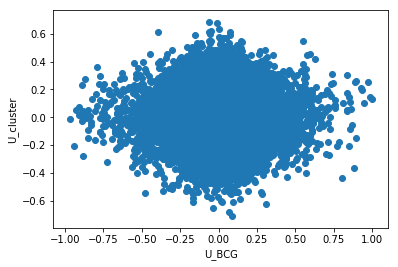

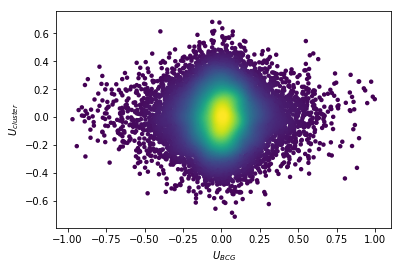

In [13]:
plt.scatter(U_BCG, all_U)
plt.xlabel('U_BCG')
plt.ylabel('U_cluster')
plt.show()

all_U_array = np.zeros(len(all_U))
for gg in range(len(all_U)):
    all_U_array[gg] = all_U[gg]
    
x = U_BCG
y = all_U_array

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=20, edgecolor='')
plt.xlabel(r'$U_{BCG}$')
plt.ylabel(r'$U_{cluster}$')
plt.show()

In [14]:
F_i0 = 4.76*10**-20 # erg s-1 cm-2 Hz-1 FOR i-band.
m1 = -2.5*np.log10(np.divide(flux_BCG, F_i0)) # apparent mag.
m2 = -2.5*np.log10(np.divide(flux_BCG2, F_i0))
m3 = -2.5*np.log10(np.divide(flux_BCG3, F_i0))

In [15]:
for i in range(len(phi_cluster)):
    if (all_U[i] > 0) and (-45 < phi_cluster[i] < 0):
        phi_cluster[i] += 90
    elif (all_U[i] < 0) and (-45 < phi_cluster[i] < 0):
        phi_cluster[i] += 180
    elif (all_U[i] < 0) and (0 < phi_cluster[i] < 45):
        phi_cluster[i] += 90
    

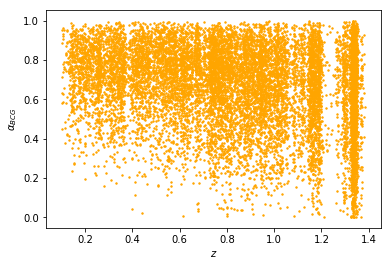

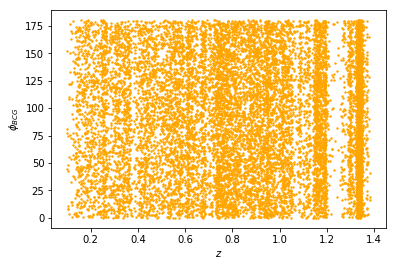

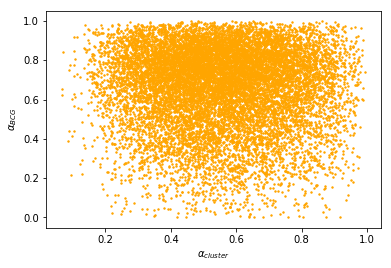

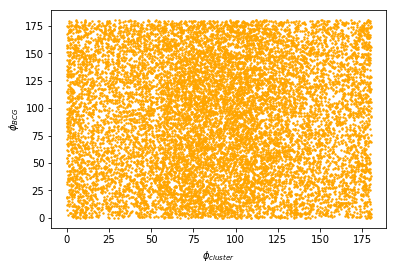

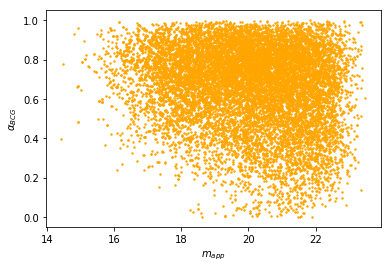

In [16]:
plt.scatter(z_BCG, alpha_BCG, c='orange', s=2)
plt.xlabel(r'$z$')
plt.ylabel(r'$\alpha_{BCG}$')
plt.show()

plt.scatter(z_BCG, phi_BCG, c='orange', s=2)
plt.xlabel(r'$z$')
plt.ylabel(r'$\phi_{BCG}$')
plt.show()

plt.scatter(alpha_cluster, alpha_BCG, c='orange', s=2)
plt.xlabel(r'$\alpha_{cluster}$')
plt.ylabel(r'$\alpha_{BCG}$')
plt.show()


plt.scatter(phi_cluster, phi_BCG, c='orange', s=2)
plt.xlabel(r'$\phi_{cluster}$')
plt.ylabel(r'$\phi_{BCG}$')
plt.show()

plt.scatter(m1, alpha_BCG, c='orange', s=2)
plt.xlabel(r'$m_{app}$')
plt.ylabel(r'$\alpha_{BCG}$')
plt.show()

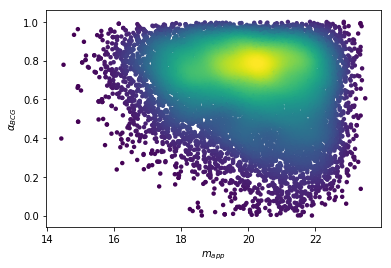

In [17]:
from scipy.stats import gaussian_kde

alpha_BCG_array = np.zeros(len(alpha_BCG))
for ff in range(len(alpha_BCG)):
    alpha_BCG_array[ff] = alpha_BCG[ff]
    
x = m1
y = alpha_BCG_array

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=20, edgecolor='')
plt.xlabel(r'$m_{app}$')
plt.ylabel(r'$\alpha_{BCG}$')
plt.show()

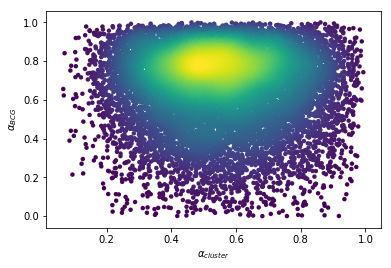

In [18]:
alpha_cluster_array = np.zeros(len(alpha_cluster))
for gg in range(len(alpha_cluster)):
    alpha_cluster_array[gg] = alpha_cluster[gg]

x = alpha_cluster_array
y = alpha_BCG_array

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=20, edgecolor='')
plt.xlabel(r'$\alpha_{cluster}$')
plt.ylabel(r'$\alpha_{BCG}$')
plt.show()

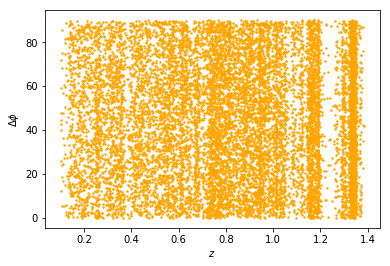

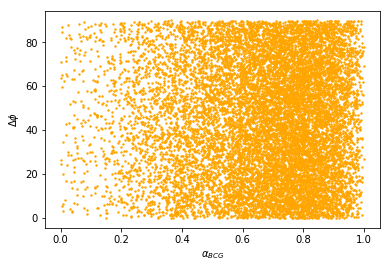

In [19]:
# alignment test

align_val = []
align_val = abs(np.subtract(phi_BCG, phi_cluster))

#for i in range(len(phi_BCG)):
#    print(str(phi_BCG[i])+' '+str(phi_cluster[i])+' '+str(align_val[i]))

for i in range(len(align_val)):
    if align_val[i] > 90:
        align_val[i] = 180 - align_val[i]

plt.scatter(z_BCG, align_val, c='orange', s=2)
plt.xlabel(r'$z$')
plt.ylabel(r'$\Delta \phi$')
plt.show()

plt.scatter(alpha_BCG, align_val, c='orange', s=2)
plt.xlabel(r'$\alpha_{BCG}$')
plt.ylabel(r'$\Delta \phi$')
plt.show()


In [20]:
# check that this is pre-ordered!

cutoff_z = 0.6
align_BCG_highz = [float(0)]
for i in range(len(align_val)):
    if z_BCG[i] > cutoff_z:
        align_BCG_highz.append(align_val[i])
del align_BCG_highz[0] 

align_BCG_lowz = [float(0)]
for i in range(len(align_val)):
    if z_BCG[i] < cutoff_z:
        align_BCG_lowz.append(align_val[i])
del align_BCG_lowz[0]

In [21]:
stats.ks_2samp(align_BCG_highz, align_BCG_lowz)

Ks_2sampResult(statistic=0.016909302623588335, pvalue=0.4295930971040541)

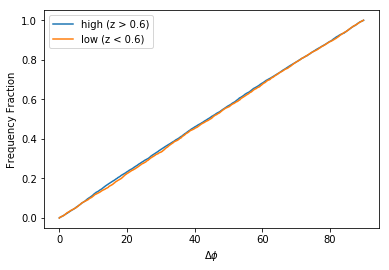

In [22]:
fig,ax = plt.subplots()
ax.plot(np.sort(align_BCG_highz),np.linspace(0.0,1.0,len(align_BCG_highz)), label='high (z > ' + str(cutoff_z)+ ')')
ax.plot(np.sort(align_BCG_lowz),np.linspace(0.0,1.0,len(align_BCG_lowz)),label='low (z < ' + str(cutoff_z)+ ')')
plt.xlabel(r'$\Delta \phi$')
plt.ylabel('Frequency Fraction')
plt.legend()
plt.show()

In [23]:
# dominance calculation
dom = []
for i in range(len(alpha_BCG)):
    dom.append(m1[i] - (m2[i]+m3[i])/2) # this is correct

In [24]:
del BCG_ra[12932]
del BCG_dec[12932]

In [25]:
# Distance of BCG from cluster

#calculate distance of BCG from centre
ra_diff = abs(np.subtract(BCG_ra, centre_ra))
dec_diff = abs(np.subtract(BCG_dec, centre_dec))
centre_dist = (ra_diff**2 + dec_diff**2)

In [26]:
N_total = 13373

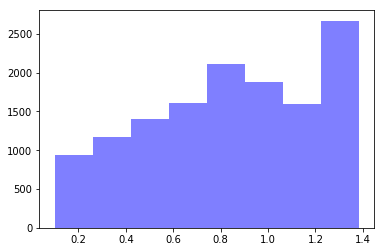

In [27]:
import matplotlib.mlab as mlab

#x = [z_01, z_02, z_03, z_04, z_05, z_06, z_07, z_08, z_09, z_10, z_11, z_12]
x = redshift
num_bins = 8
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.show()

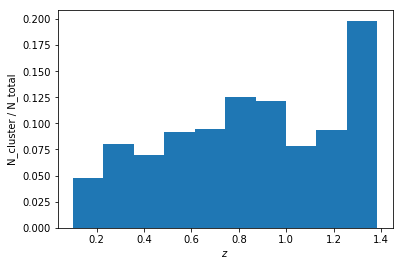

In [28]:
data = redshift
plt.hist(data, weights=np.ones(len(data)) / len(data))
plt.xlabel(r'$z$')
plt.ylabel('N_cluster / N_total')
plt.show()

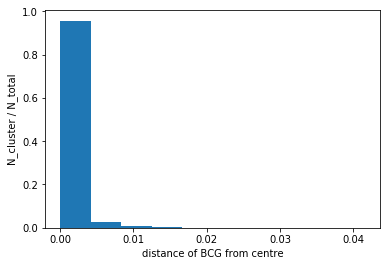

In [29]:
# check units on this one.
data = centre_dist
plt.hist(data, weights=np.ones(len(data)) / len(data))
plt.xlabel('distance of BCG from centre')
plt.ylabel('N_cluster / N_total')
plt.show()

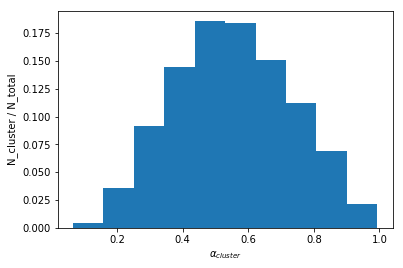

In [30]:
data = alpha_cluster
plt.hist(data, weights=np.ones(len(data)) / len(data))
plt.xlabel(r'$\alpha_{cluster}$')
plt.ylabel('N_cluster / N_total')
plt.show()

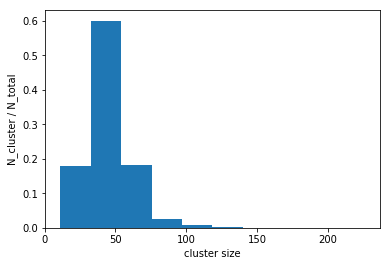

In [31]:
data = clu_size
plt.hist(data, weights=np.ones(len(data)) / len(data))
plt.xlabel('cluster size')
plt.ylabel('N_cluster / N_total')
plt.show()

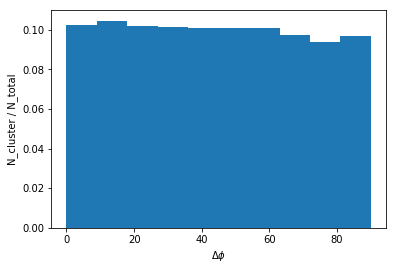

In [32]:
data = align_val
plt.hist(data, weights=np.ones(len(data)) / len(data))
plt.xlabel(r'$\Delta \phi$')
plt.ylabel('N_cluster / N_total')
plt.show()

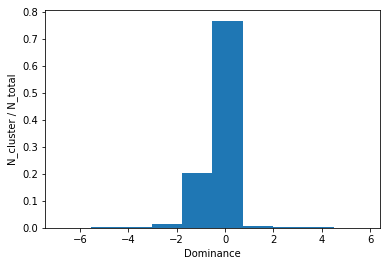

In [33]:
data = dom
plt.hist(data, weights=np.ones(len(data)) / len(data))
plt.xlabel('Dominance')
plt.ylabel('N_cluster / N_total')
plt.show()

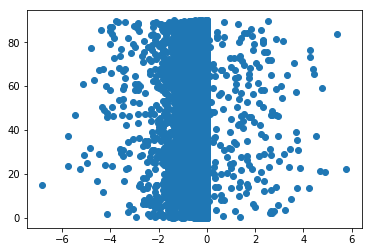

In [34]:
plt.scatter(dom, align_val)
plt.show()

In [35]:
all_w

[array([0.2055799 , 0.336718  , 0.06205157, 1.        , 0.4127302 ,
        0.06518541, 0.00154485, 0.0056141 , 0.03003528, 0.09959142,
        0.780572  , 0.00905401, 0.0107449 , 0.926379  , 1.        ,
        0.5133334 , 0.1753872 , 0.4998017 , 0.5570905 , 0.00899303,
        0.00730047, 0.05200606, 0.00887232, 0.4743079 , 1.        ,
        1.        , 0.00224612, 0.2084047 , 0.6358233 , 1.        ,
        0.1133539 , 0.07563847, 0.00299755, 0.01468192, 0.2678885 ,
        1.        , 0.00109334, 0.00248472, 0.05161801, 0.1266474 ,
        1.        , 0.06908457, 0.00106508, 0.00229306, 1.        ,
        0.393414  , 1.        , 0.3309354 , 0.6672169 , 0.01012162,
        0.1103501 ]),
 array([0.00350558, 1.        , 0.01920621, 0.05797001, 0.03689109,
        0.6871872 , 0.4465218 , 0.1740785 , 1.        , 0.08633835,
        0.00212507, 0.8516621 , 0.00200312, 0.1740859 , 0.03875652,
        0.4651204 , 0.03157778, 0.1574488 , 0.1479714 , 0.9371654 ,
        0.1039221 , 0.0154

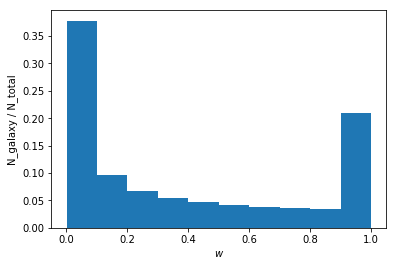

In [37]:
data = all_w_expand
plt.hist(data, weights=np.ones(len(data)) / len(data))
plt.xlabel(r'$w$')
plt.ylabel('N_galaxy / N_total')
plt.show()

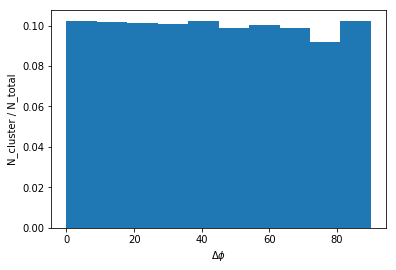

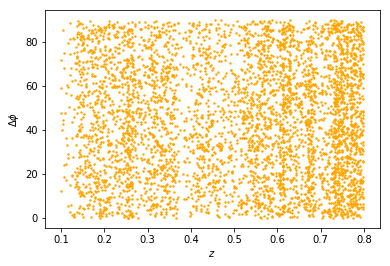

In [43]:
new_align_val = []
new_redshift = []
for i in range(len(align_val)):
    if redshift[i] < 0.8 and clu_size[i] > 30:
        new_redshift.append(redshift[i])
        new_align_val.append(align_val[i])
        
data = new_align_val
plt.hist(data, weights=np.ones(len(data)) / len(data))
plt.xlabel(r'$\Delta \phi$')
plt.ylabel('N_cluster / N_total')
plt.show()

plt.scatter(new_redshift, new_align_val, c='orange', s=2)
plt.xlabel(r'$z$')
plt.ylabel(r'$\Delta \phi$')
plt.show()

In [44]:
# check that this is pre-ordered!

cutoff_z = 0.6
align_BCG_highz = [float(0)]
for i in range(len(new_align_val)):
    if z_BCG[i] > cutoff_z:
        align_BCG_highz.append(new_align_val[i])
del align_BCG_highz[0] 

align_BCG_lowz = [float(0)]
for i in range(len(new_align_val)):
    if z_BCG[i] < cutoff_z:
        align_BCG_lowz.append(new_align_val[i])
del align_BCG_lowz[0]

stats.ks_2samp(align_BCG_highz, align_BCG_lowz)



Ks_2sampResult(statistic=0.03266305088569402, pvalue=0.27723982996055424)

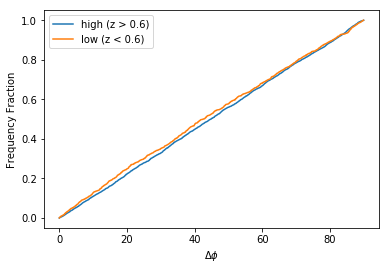

In [45]:
fig,ax = plt.subplots()
ax.plot(np.sort(align_BCG_highz),np.linspace(0.0,1.0,len(align_BCG_highz)), label='high (z > ' + str(cutoff_z)+ ')')
ax.plot(np.sort(align_BCG_lowz),np.linspace(0.0,1.0,len(align_BCG_lowz)),label='low (z < ' + str(cutoff_z)+ ')')
plt.xlabel(r'$\Delta \phi$')
plt.ylabel('Frequency Fraction')
plt.legend()
plt.show()

In [46]:
new_dom = []
new_align_val = []
for i in range(len(dom)):
    if dom[i] < 0:
        new_dom.append(dom[i])
        new_align_val.append(align_val[i])

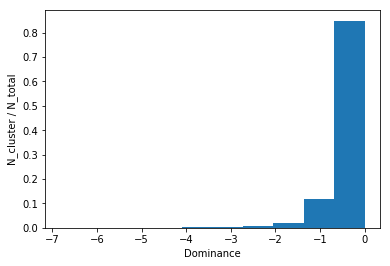

In [47]:
data = new_dom
plt.hist(data, weights=np.ones(len(data)) / len(data))
plt.xlabel('Dominance')
plt.ylabel('N_cluster / N_total')
plt.show()

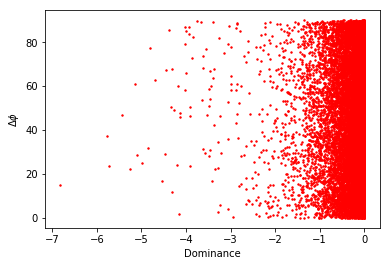

In [48]:
plt.scatter(new_dom, new_align_val, c='red', s=2)
plt.xlabel('Dominance')
plt.ylabel(r'$\Delta \phi$')
plt.show()